In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as plt

In [2]:
# Load employee_info source table
data1 = pd.read_csv("/Users/leanhe/Desktop/Github/Employee_Churn_Analytics/Employee_info.csv")

In [3]:
# Explore table information: data size, columns, data quality, data type
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1478 non-null   float64
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1479 non-null   object 
 14  HourlyRa

# Churn Correlation Deep Dive

## 1. Data Cleaning

### Step 1: Drop Irrelevant Columns and Columns with No Variance

In [4]:
data1.drop(columns=[
    'Over18', 
    'EmpID', 
    'EmployeeNumber', 
    'StandardHours', 
    'EducationField', 
    'EmployeeCount',
    'JobInvolvement',
    'PercentSalaryHike',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'MaritalStatus',
    'Gender'
], inplace=True)

### Step 2: Remove Redundant Features with Overlapping Information
Some columns convey the same information at different levels of granularity—for example, both “Age” and “AgeGroup” reflect age-related data. In such cases, I retain the grouped or more general column and remove the one with overly detailed values to reduce redundancy and simplify the analysis.  
- Age/AgeGroup: Keep AgeGroup
- DailyRate/HourlyRate/MonthlyRate/MonthlyIncome/SalarySlab: Keep SalarySlab

In [5]:
data1.drop(columns=[
        'Age', 
        'DailyRate', 
        'HourlyRate',
        'MonthlyRate', 
        'MonthlyIncome',
        'EnvironmentSatisfaction',
        'RelationshipSatisfaction'
], inplace=True)

### Step 3: Removing Duplications

In [6]:
print(data1.duplicated().any())
print(data1.duplicated().sum())

True
7


In [7]:
data1[data1.duplicated()]

,AgeGroup,Attrition,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,JobRole,JobSatisfaction,SalarySlab,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
211,26-35,No,Travel_Rarely,Research & Development,4.0,3,2,Manufacturing Director,2.0,5k-10k,1,Yes,4,1,3,6,2,0,3.0
328,26-35,No,Travel_Rarely,Research & Development,28.0,4,1,Research Scientist,1.0,Upto 5k,1,No,3,0,1,5,4,0,4.0
458,26-35,No,Non-Travel,Research & Development,5.0,3,2,Manufacturing Director,1.0,5k-10k,0,No,3,0,3,9,4,1,7.0
655,26-35,No,TravelRarely,Research & Development,8.0,3,2,Laboratory Technician,3.0,Upto 5k,2,No,3,0,4,4,3,1,2.0
954,36-45,No,Travel_Rarely,Sales,24.0,1,4,Sales Executive,4.0,10k-15k,0,No,3,1,2,20,9,9,6.0
1305,46-55,No,Travel_Frequently,Sales,2.0,3,2,Sales Executive,2.0,5k-10k,2,No,3,0,2,9,6,0,8.0
1336,46-55,Yes,Travel_Rarely,Sales,28.0,3,3,Sales Executive,1.0,10k-15k,4,Yes,3,1,3,3,2,2,0.0


In [8]:
# List every column that makes these rows “duplicated”

dupes = data1[data1.duplicated(keep=False)]
dupes.sort_values(list(data1.columns)).reset_index(drop=True)

,AgeGroup,Attrition,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,JobRole,JobSatisfaction,SalarySlab,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,26-35,No,Non-Travel,Research & Development,5.0,3,2,Manufacturing Director,1.0,5k-10k,0,No,3,0,3,9,4,1,7.0
1,26-35,No,Non-Travel,Research & Development,5.0,3,2,Manufacturing Director,1.0,5k-10k,0,No,3,0,3,9,4,1,7.0
2,26-35,No,TravelRarely,Research & Development,8.0,3,2,Laboratory Technician,3.0,Upto 5k,2,No,3,0,4,4,3,1,2.0
3,26-35,No,TravelRarely,Research & Development,8.0,3,2,Laboratory Technician,3.0,Upto 5k,2,No,3,0,4,4,3,1,2.0
4,26-35,No,Travel_Rarely,Research & Development,4.0,3,2,Manufacturing Director,2.0,5k-10k,1,Yes,4,1,3,6,2,0,3.0
5,26-35,No,Travel_Rarely,Research & Development,4.0,3,2,Manufacturing Director,2.0,5k-10k,1,Yes,4,1,3,6,2,0,3.0
6,26-35,No,Travel_Rarely,Research & Development,28.0,4,1,Research Scientist,1.0,Upto 5k,1,No,3,0,1,5,4,0,4.0
7,26-35,No,Travel_Rarely,Research & Development,28.0,4,1,Research Scientist,1.0,Upto 5k,1,No,3,0,1,5,4,0,4.0
8,36-45,No,Travel_Rarely,Sales,24.0,1,4,Sales Executive,4.0,10k-15k,0,No,3,1,2,20,9,9,6.0
9,36-45,No,Travel_Rarely,Sales,24.0,1,4,Sales Executive,4.0,10k-15k,0,No,3,1,2,20,9,9,6.0


In [9]:
# Drop duplications
data1 = data1.drop_duplicates()
print(data1.duplicated().any())
print(data1.duplicated().sum())

False
0


### Step 4: Filling Null values

In [10]:
# calculated the number of missing entries per row to assess data quality.
null_rows = data1[data1.isna().any(axis=1)].copy()
null_rows['null_count'] = null_rows.isna().sum(axis=1)
null_rows

,AgeGroup,Attrition,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,JobRole,JobSatisfaction,SalarySlab,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,null_count
13,18-25,Yes,Travel_Rarely,Sales,NaN,3,1,Sales Representative,2.0,Upto 5k,1,Yes,3,0,4,1,0,0,0.0,1
19,18-25,Yes,Travel_Rarely,Research & Development,10.0,1,1,Research Scientist,NaN,Upto 5k,1,Yes,3,0,3,1,0,1,1.0,1
28,18-25,No,Travel_Rarely,Research & Development,15.0,2,1,Research Scientist,4.0,Upto 5k,1,No,3,0,3,0,0,0,NaN,1
31,18-25,No,Non-Travel,Sales,9.0,2,1,Sales Representative,4.0,Upto 5k,1,No,4,0,2,3,2,2,NaN,1
37,18-25,Yes,Travel_Frequently,Research & Development,10.0,2,1,Laboratory Technician,NaN,Upto 5k,1,No,4,0,1,2,2,2,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,46-55,No,Travel_Rarely,Research & Development,3.0,3,3,Manufacturing Director,3.0,5k-10k,2,Yes,3,0,3,5,4,0,NaN,1
1375,46-55,No,Travel_Rarely,Research & Development,5.0,3,5,Manager,3.0,15k+,4,No,3,1,2,14,13,4,NaN,1
1448,55,No,Travel_Rarely,Research & Development,1.0,4,2,Healthcare Representative,3.0,5k-10k,2,No,3,0,3,3,2,1,NaN,1
1465,55,No,Travel_Rarely,Research & Development,3.0,3,1,Laboratory Technician,1.0,Upto 5k,4,Yes,4,3,2,1,0,0,NaN,1


Out of 1,480 rows, 61 contain null values, with most having only a single missing entry.

In [11]:
null_rows.isna().sum(axis=1).gt(1).sum()

0

Since fewer than 5% of rows contain missing values, dropping them would typically be acceptable. However, assuming stakeholders prefer to retain all data, I’ve opted to impute the missing values based on informed judgment.

In [12]:
null_rows.isna().sum()

AgeGroup                    0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            2
Education                   0
JobLevel                    0
JobRole                     0
JobSatisfaction             2
SalarySlab                  0
NumCompaniesWorked          0
OverTime                    0
PerformanceRating           0
StockOptionLevel            0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager       57
null_count                  0
dtype: int64

Columns with missing value:
DistanceFromHome(float64), Gender(object), HourlyRate(float64), JobSatisfaction(float64), YearswithCurrManager(float64).
Since ‘Gender’ is categorical and ‘JobSatisfaction’ is ordinal, I filled missing values using the mode. For numerical columns, I assessed skewness to choose between mean, median, or mode for imputation.

<AxesSubplot:>

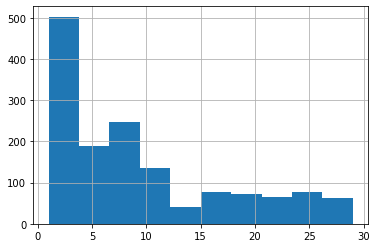

In [13]:
data1['DistanceFromHome'].hist() # right-skewed

<AxesSubplot:>

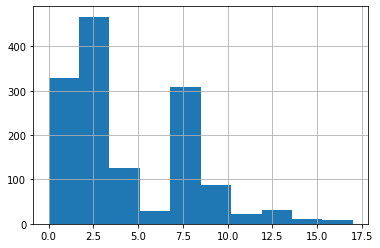

In [14]:
data1['YearsWithCurrManager'].hist() #right-skewed

I'm going to fill with median for column 'DistanceFromHome' and 'YearsWithCurrManager' since they are right-skewed. If column is not skewed, I fill with mean.

In [15]:
# Categorical & ordinal
data1['JobSatisfaction'].fillna(data1['JobSatisfaction'].mode()[0], inplace=True)

# Numeric
data1['DistanceFromHome'].fillna(data1['DistanceFromHome'].median(), inplace=True)
data1['YearsWithCurrManager'].fillna(data1['YearsWithCurrManager'].median(), inplace=True)

In [16]:
# Check if there's still null values
data1.isna().sum()

AgeGroup                   0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
JobLevel                   0
JobRole                    0
JobSatisfaction            0
SalarySlab                 0
NumCompaniesWorked         0
OverTime                   0
PerformanceRating          0
StockOptionLevel           0
WorkLifeBalance            0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64

### Step 5: Checking Inconsistent Formatting

In [17]:
categorical_cols = data1.select_dtypes(include='object').columns

In [18]:
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data1[col].unique())


Column: AgeGroup
['18-25' '26-35' '36-45' '46-55' '55']

Column: Attrition
['Yes' 'No']

Column: BusinessTravel
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel' 'TravelRarely']

Column: Department
['Research & Development' 'Sales' 'Human Resources']

Column: JobRole
['Laboratory Technician' 'Sales Representative' 'Research Scientist'
 'Human Resources' 'Manufacturing Director' 'Sales Executive'
 'Healthcare Representative' 'Research Director' 'Manager']

Column: SalarySlab
['Upto 5k' '5k-10k' '10k-15k' '15k+']

Column: OverTime
['No' 'Yes']


All values are standardized and consistently formatted.

## 2. Data Processing

### Step 1: Categorical Variables - Binary Encoding
For column **"Attrition"**, I convert values "Yes/No" into 0/1, and rename it to "Churn".  
For column **"Gender"**, I convert values "Male/Female" into 0/1.  
For column **"OverTime**, I convert values "No/Yes" into 0/1.

In [19]:
# Convert Yes/No to 1/0
data1['Attrition'] = data1['Attrition'].map({'Yes': 1, 'No': 0})
data1['OverTime'] = data1['OverTime'].map({'Yes': 1, 'No': 0})

# Rename column Attrition
data1.rename(columns={'Attrition': 'Churn'}, inplace=True)

In [20]:
print(data1['Churn'].unique())
print(data1['OverTime'].unique())

[1 0]
[0 1]


### Step 2: Ordinal Encoding 
For column **"AgeGroup"**, I use a rank from 0 to 4 for '18-25', '26-35', '36-45', '46-55', '55'.  
For column **"SalarySlab"**, I use a rank from 0 to 3 for 'Upto 5k' '5k-10k' '10k-15k' '15k+'.

In [21]:
#1. Change the type from object to category
data1.AgeGroup = data1.AgeGroup.astype("category")
data1.SalarySlab = data1.SalarySlab.astype("category")

#2. Give the values an order
data1.AgeGroup = data1.AgeGroup.cat.reorder_categories(['18-25', '26-35', '36-45', '46-55', '55'])
data1.SalarySlab = data1.SalarySlab.cat.reorder_categories(['Upto 5k','5k-10k','10k-15k','15k+'])

#3. Encode categories with integer values
data1.AgeGroup = data1.AgeGroup.cat.codes
data1.SalarySlab = data1.SalarySlab.cat.codes

In [22]:
print(data1['AgeGroup'].unique())
print(data1['AgeGroup'].unique())

[0 1 2 3 4]
[0 1 2 3 4]


### Step 3: Nominal Categories - One-hot Encoding (Dummy Variables)
Generate dummy values for nominal categories, and drop one level per column to avoid the dummy variable trap.

In [23]:
data1 = pd.get_dummies(data1, columns=[
    'BusinessTravel', 
    'Department', 
    'JobRole'
], drop_first=True)

In [24]:
print(data1.isnull().sum().sum())
print(data1.dtypes.value_counts())
print(data1.duplicated().sum())

0
bool       13
int64      11
float64     3
int8        2
Name: count, dtype: int64
0


## What's the overall churn rate?

In [25]:
#Turnover rate = number of employee left/ total number of employee

#Total number of employee
total_e = len(data1)
print(total_e)

#number of employee left: column "churn" = 1
#count the number of 1s and 0s under column "churn"
churn_c = data1.Churn.value_counts()

#Calculate churn
churn_c/total_e

1473


Churn
0    0.839104
1    0.160896
Name: count, dtype: float64

As of June 2024, out of 1473 employees, 16.1% of employees have left the company, while 83.9% remained employed.

## What are the key contributing factors of voluntary turnover in this workforce?

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#Generate correlation matrix
corr_matrix = data1.corr()

# Get correlation with target 'Churn' and sort by absolute value
churn_corr = corr_matrix["Churn"].drop("Churn").sort_values(key=abs, ascending=False)

# Display only strong correlations (e.g., above 0.1 or below -0.1)
strong_corr = churn_corr[abs(churn_corr) > 0.1]
print(strong_corr)

OverTime                            0.246532
JobLevel                           -0.168926
YearsInCurrentRole                 -0.160302
YearsWithCurrManager               -0.157813
JobRole_Sales Representative        0.155247
SalarySlab                         -0.151820
AgeGroup                           -0.148801
StockOptionLevel                   -0.136939
YearsAtCompany                     -0.134106
BusinessTravel_Travel_Frequently    0.114604
JobSatisfaction                    -0.100378
Name: Churn, dtype: float64


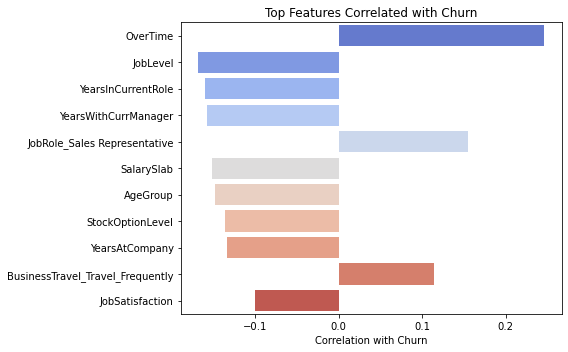

In [28]:
# Plot top features correlated with Churn
plt.figure(figsize=(8, 5))
sns.barplot(x=strong_corr.values, y=strong_corr.index, palette="coolwarm")
plt.title("Top Features Correlated with Churn")
plt.xlabel("Correlation with Churn")
plt.tight_layout()
plt.show()

According to the correlation plot, I can see that, the top 5 strongest contributing factors to churn is  
- OverTime: 0.25 (longer OT, more likely to churn)
- JobLevel: -0.17 (the higher the job level, the less likely to churn)
- YearsInCurrentRole: -0.16 (the longer experience in current role, the less likely to churn)
- YearsWithCurrentManager: -0.16 (the longer experience with current manager, the less likely to churn)
- SalarySlab: -0.15 (the lower the salary, the more likely to churn)

## Which departments, job roles, or age group have the highest churn rates, and why?

In [29]:
# Create an In-Memory SQLite Database and Load the Table
data2 = pd.read_csv("/Users/leanhe/Desktop/Github/Employee_Churn_Analytics/Employee_info.csv")
data2.columns

Index(['EmpID', 'Age', 'AgeGroup', 'Attrition', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'SalarySlab',
       'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [30]:
# Fill Null Values
data2['Gender'].fillna(data2['Gender'].mode()[0], inplace=True)
data2['JobSatisfaction'].fillna(data2['JobSatisfaction'].mode()[0], inplace=True)
data2['DistanceFromHome'].fillna(data2['DistanceFromHome'].median(), inplace=True)
data2['HourlyRate'].fillna(data2['HourlyRate'].mean(), inplace=True)
data2['YearsWithCurrManager'].fillna(data2['YearsWithCurrManager'].median(), inplace=True)

# Remove Duplicates
data2 = data2.drop_duplicates()

# Convert Yes/No to 1/0
data2.loc[:, 'Attrition'] = data2['Attrition'].map({'Yes': 1, 'No': 0})
data2.loc[:, 'Gender'] = data2['Gender'].map({'Female': 1, 'Male': 0})
data2.loc[:, 'OverTime'] = data2['OverTime'].map({'Yes': 1, 'No': 0})
data2 = data2.rename(columns={'Attrition': 'Churn'})

# Load to SQL

from sqlalchemy import create_engine

engine = create_engine('sqlite:///mydata.db')

# Write the DataFrame to SQL
data2.to_sql('employee_info', con=engine, index=False, if_exists='replace')

1473

In [31]:
%load_ext sql
%sql sqlite:///mydata.db

In [32]:
%%sql
SELECT 
    *
FROM employee_info
LIMIT 5;

 * sqlite:///mydata.db
Done.


EmpID,Age,AgeGroup,Churn,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,SalarySlab,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
RM297,18,18-25,1,Travel_Rarely,230,Research & Development,3.0,3,Life Sciences,1,405,3,0,54.0,3,1,Laboratory Technician,3.0,Single,1420,Upto 5k,25233,1,Y,0,13,3,3,80,0,0,2,3,0,0,0,0.0
RM302,18,18-25,0,Travel_Rarely,812,Sales,10.0,3,Medical,1,411,4,1,69.0,2,1,Sales Representative,3.0,Single,1200,Upto 5k,9724,1,Y,0,12,3,1,80,0,0,2,3,0,0,0,0.0
RM458,18,18-25,1,Travel_Frequently,1306,Sales,5.0,3,Marketing,1,614,2,0,69.0,3,1,Sales Representative,2.0,Single,1878,Upto 5k,8059,1,Y,1,14,3,4,80,0,0,3,3,0,0,0,0.0
RM728,18,18-25,0,Non-Travel,287,Research & Development,5.0,2,Life Sciences,1,1012,2,0,73.0,3,1,Research Scientist,4.0,Single,1051,Upto 5k,13493,1,Y,0,15,3,4,80,0,0,2,3,0,0,0,0.0
RM829,18,18-25,1,Non-Travel,247,Research & Development,8.0,1,Medical,1,1156,3,0,80.0,3,1,Laboratory Technician,3.0,Single,1904,Upto 5k,13556,1,Y,0,12,3,4,80,0,0,0,3,0,0,0,0.0


In [33]:
%%sql
SELECT 
    Department,
    ROUND(SUM(Churn) * 1.0 / COUNT(*),2) AS churn_rate
FROM employee_info
GROUP BY 1
Order BY 2 DESC;

 * sqlite:///mydata.db
Done.


Department,churn_rate
Sales,0.21
Human Resources,0.19
Research & Development,0.14


In [34]:
%%sql
SELECT 
    JobRole,
    ROUND(SUM(Churn) * 1.0 / COUNT(*),2) AS churn_rate
FROM employee_info
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///mydata.db
Done.


JobRole,churn_rate
Sales Representative,0.39
Laboratory Technician,0.24
Human Resources,0.23
Sales Executive,0.17
Research Scientist,0.16
Manufacturing Director,0.07
Healthcare Representative,0.07
Manager,0.05
Research Director,0.03


In [35]:
%%sql
SELECT 
    AgeGroup,
    ROUND(SUM(Churn) * 1.0 / COUNT(*),2) AS churn_rate
FROM employee_info
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///mydata.db
Done.


AgeGroup,churn_rate
18-25,0.36
26-35,0.19
55,0.17
46-55,0.12
36-45,0.09


Sales department and sales role have the highest churn rates. Age group from 18 to 25 (youngest age group) has the highest churn rate.  
**Why?**  
To find out the possible reason, I take a look at the correlation with Department_Sales and AgeGroup = 0.

In [36]:
# For Sales department only
sales_group = data1[data1["Department_Sales"] == True]

# Compare against other departments
non_sales = data1[data1["Department_Sales"] == False]

# Compare distributions or averages
print("OT:", sales_group["OverTime"].mean(), non_sales["OverTime"].mean())
print("YearsSinceLastPromotion:", sales_group["YearsSinceLastPromotion"].mean(), non_sales["YearsSinceLastPromotion"].mean())

OT: 0.28635346756152125 0.2807017543859649
YearsSinceLastPromotion: 2.348993288590604 2.112085769980507


Sales team has the higher average of OverTime and YearsSinceLastPromotion comparing with other departments. Those 2 factors can be reasons that sales employees are more likely to churn.

## Can we identify at-risk employees early enough to intervene?

To achieve that, I tested 3 different models, and found the best model (logistic regression) for more accurate prediction. 

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [38]:
# Define features (x) and target (y)

x = data1.drop("Churn", axis = 1)
y = data1["Churn"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

Model 1: Random Forest

              precision    recall  f1-score   support

        Stay       0.85      0.99      0.91       365
       Leave       0.72      0.17      0.27        77

    accuracy                           0.84       442
   macro avg       0.79      0.58      0.59       442
weighted avg       0.83      0.84      0.80       442



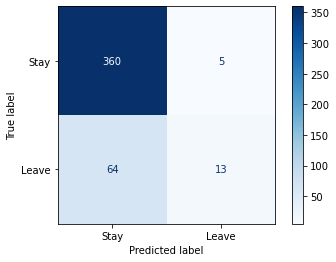

In [39]:
# build and retrain the random forest model
rf = RandomForestClassifier(random_state=123)
rf.fit(x_train, y_train)

# Get top 20 features from the new model
importances = pd.Series(rf.feature_importances_, index=x_train.columns)
top_features = importances.sort_values(ascending=False).head(20).index

# Subset the new split
x_train_top20 = x_train[top_features]
x_test_top20 = x_test[top_features]

# Now train your final model
rf_top20 = RandomForestClassifier(random_state=123)
rf_top20.fit(x_train_top20, y_train)

#Predict
y_pred_rf = rf_top20.predict(x_test_top20)

#Evaluate
print(classification_report(y_test, y_pred_rf, target_names=["Stay", "Leave"]))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Stay", "Leave"])
disp.plot(cmap = "Blues")

Model 2: Decision Tree

In [40]:
# Create Decision Tree model

pruned = DecisionTreeClassifier(max_depth = 10, random_state = 123) #the tree only ask max of 4 questions in a row, reducing complexity
pruned.fit(x_train_top20, y_train)

# Apply model
y_pruned_pred = pruned.predict(x_test_top20)

              precision    recall  f1-score   support

        Stay       0.86      0.89      0.87       365
       Leave       0.37      0.31      0.34        77

    accuracy                           0.79       442
   macro avg       0.61      0.60      0.61       442
weighted avg       0.77      0.79      0.78       442



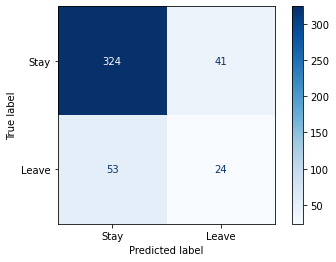

In [41]:
# Evaluate model: Precision, Recall, F1
print(classification_report(y_test, y_pruned_pred, target_names = ["Stay", "Leave"]))

#Confusion matrix
cm = confusion_matrix(y_test, y_pruned_pred)

#Display it with labels
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Stay", "Leave"])
disp.plot(cmap = "Blues")

A low precision and recall score here shows that the model is not doing a better job than random guessing.  

Model 3: XGB

In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

📋 Classification Report:

              precision    recall  f1-score   support

        Stay       0.87      0.96      0.91       365
       Leave       0.62      0.31      0.41        77

    accuracy                           0.85       442
   macro avg       0.74      0.64      0.66       442
weighted avg       0.82      0.85      0.82       442

📉 Confusion Matrix:


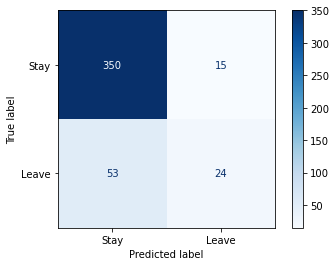

In [43]:
# XGB model
xgb = XGBClassifier(eval_metric='logloss', random_state=123)
xgb.fit(x_train_top20, y_train)

# Step 4: Make predictions
y_pred_xgb = xgb.predict(x_test_top20)

# Step 5: Evaluate the model
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_xgb, target_names=["Stay", "Leave"]))

print("📉 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stay", "Leave"])
disp.plot(cmap="Blues")
plt.show()

Model 4 (Best Performer): Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

📋 Classification Report:

              precision    recall  f1-score   support

        Stay       0.92      0.75      0.83       365
       Leave       0.37      0.69      0.48        77

    accuracy                           0.74       442
   macro avg       0.64      0.72      0.65       442
weighted avg       0.82      0.74      0.77       442



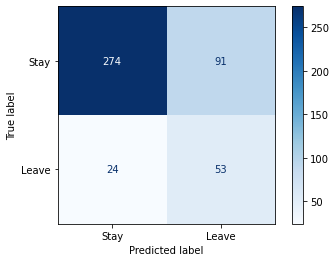

In [45]:
# Train logistic regression with class weighting
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=123)
logreg.fit(x_train_top20, y_train)

# Predict
y_pred_logreg = logreg.predict(x_test_top20)

# Evaluate
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_logreg, target_names=["Stay", "Leave"]))

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["Stay", "Leave"])
disp.plot(cmap="Blues")
plt.show()

Logistic regression model performs the best at recalling. HR can identify at-risk employees and prevent losing top talant by offering training, mentorship, or retention bonuses.

In [48]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=123),
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=123),
    "Decision Tree": DecisionTreeClassifier(max_depth = 10, random_state = 123)
}

results = {}
for name, model in models.items():
    model.fit(x_train_top20, y_train)
    y_pred = model.predict(x_test_top20)

    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Accuracy": accuracy,
        "Precision (Leave)": report["1"]["precision"],
        "Recall (Leave)": report["1"]["recall"],
        "F1-score (Leave)": report["1"]["f1-score"]
    }
    
summary_df = pd.DataFrame(results).T
summary_df = summary_df.round(2)
summary_df

,Accuracy,Precision (Leave),Recall (Leave),F1-score (Leave)
Logistic Regression,0.74,0.37,0.69,0.48
Random Forest,0.84,0.72,0.17,0.27
XGBoost,0.85,0.62,0.31,0.41
Decision Tree,0.79,0.37,0.31,0.34


### How to Use this Prediction Model?
Run the model on updated employee data regularly and flag high-risk employees and take actions. Track whether interventions reduce churn

In [49]:
data3 = pd.read_csv("/Users/leanhe/Desktop/Github/Employee_Churn_Analytics/Employee_info2.csv")

In [50]:
#Data Processing
data3.drop(columns=[
    'Over18', 
    'EmployeeNumber', 
    'StandardHours', 
    'EducationField', 
    'EmployeeCount',
    'JobInvolvement',
    'PercentSalaryHike',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'MaritalStatus',
    'Gender',
    'Age', 
    'DailyRate', 
    'HourlyRate',
    'MonthlyRate', 
    'MonthlyIncome'    
], inplace=True)

data3.dropna(inplace=True)
data3.drop_duplicates(inplace=True)

# Convert Yes/No to 1/0
data3['Attrition'] = data3['Attrition'].map({'Yes': 1, 'No': 0})
data3['OverTime'] = data3['OverTime'].map({'Yes': 1, 'No': 0})

# Rename column Attrition
data3.rename(columns={'Attrition': 'Churn'}, inplace=True)

#1. Change the type from object to category
data3.AgeGroup = data3.AgeGroup.astype("category")
data3.SalarySlab = data3.SalarySlab.astype("category")

#2. Give the values an order
data3.AgeGroup = data3.AgeGroup.cat.reorder_categories(['18-25', '26-35', '36-45', '46-55', '55'])
data3.SalarySlab = data3.SalarySlab.cat.reorder_categories(['Upto 5k','5k-10k','10k-15k','15k+'])

#3. Encode categories with integer values
data3.AgeGroup = data3.AgeGroup.cat.codes
data3.SalarySlab = data3.SalarySlab.cat.codes

data3 = pd.get_dummies(data3, columns=[
    'BusinessTravel', 
    'Department', 
    'JobRole'
], drop_first=True)

In [51]:
# Predict churn probability for all employees in data1
churn_probs = logreg.predict_proba(data3[top_features])[:, 1]

data3["Churn_Probability"] = churn_probs
result = data3[["EmpID", "Churn_Probability"]]

# View top 10 employees most likely to churn
result.sort_values(by="Churn_Probability", ascending=False).head(10)

,EmpID,Churn_Probability
88,RM1061,0.980427
925,RM670,0.962944
2,RM458,0.949988
113,RM912,0.949699
54,RM1274,0.949569
246,RM1069,0.940476
30,RM358,0.938780
344,RM217,0.937249
1255,RM1224,0.934379
512,RM1327,0.934347


The logistic regression model successfully identified the top 10 employees with the highest predicted risk of churn, aligning well with actual outcomes. This suggests the model is effective and reliable. HR teams can confidently leverage this model as an early warning system to proactively identify at-risk employees and take targeted retention actions.

## Tableau Visualization Data Preparation

I handle missing and duplicate rows in Python by removing them, while any additional data manipulation will be performed within Tableau using calculated fields.

In [ ]:
data_t = pd.read_csv("/Users/leanhe/Desktop/Github/HR_Analytics/Employee_info.csv")
data_t.dropna(inplace=True)
data_t.drop_duplicates(inplace=True)

In [ ]:
data_t.to_csv("/Users/leanhe/Desktop/Github/HR_Analytics/employee_data_tableau.csv", index=False)